# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.



## 1. Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer

##### Question 1:

Let's calculate Gain for each feature:
1. For 1st feature: 0.39
2. For 2nd feature: 0
3. For 3rd feature: 0


So, as a root we choose 1t feature and now we have next nodes:

Feature 1 == 1, node A:
$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
\end{aligned}
$$

Feature 1 == 0, node B:
$$
\begin{aligned}
((0, 0, 1), 0)
\end{aligned}
$$

Node B is a final leaf with 0 entropy. 

For the node A, let's calculate gain for next 2 features:
1. For 2nd feature: 0.5
2. For 3nd feature: 0.5

So, we could use one of them with the same gain.

Let's now calculate the training error:

In the final tree from this algorythm we gor 3 leafes: {0, 1, [1,0]} or {0,[1,0],0} in both cases 1 of 4 points is assigned incorrected, so the error is 1/4




#### Answer

##### Question 2:

1. Split by 2nd feature in subsets

A:
$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 1, 0), 0)\\
\end{aligned}
$$

B:
$$
\begin{aligned}
((1, 0, 0), 1)\\
((0, 0, 1), 0)
\end{aligned}
$$

2. Then split A by the 3rd feature and B by the 1st feature and we got the set {1,0,1,0} with the train error is 0.


### Comments:

As we see not for all cases the tree's greedy algorythm give us the best result. In this case we use the features that by themselfes not make our split better but together works as a XOR and make a perfect split. 

## 2. Implementing Decision Tree From Scratch
In this exercise you will need to implement a simple version of Decision Tree from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes).

* Compelete the skeleton class below
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `min_leaf` is the minimal number of samples in each leaf node
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(nlgn)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* To check your decision tree implementation, use the boston dataset (`from sklearn.datasets import load_boston`) split the data set into train and test using (`from sklearn.model_selection import train_test_split`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
    for min_leaf in [1,5,10,100]:
      dt = DecisionTree(X, y, n, sz, min_leaf)
      mse = # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = dt.predict(X_train)  # forest is the chosen model
  plt.scatter(y_hat, y_test)
  ```

In [348]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
plt.style.use('bmh')

In [349]:
class DecisionTree(BaseEstimator,ClassifierMixin):
  def __init__(self, min_leaf):
    self.X = None
    self.y = None
    self.min_leaf = min_leaf
    self.right = None
    self.left = None
    self.feature = None
    self.feature_value = None

  def fit(self, X, y, depth=0):
    self.X = pd.DataFrame(X)
    self.y = np.array(y)
    if (self.y.shape[0] <= self.min_leaf) or (np.unique(self.y).shape[0] == 1):
      pass
    else:
      self.learn_the_feature()
      index_left = self.X.iloc[:,self.feature]  < self.feature_value
      index_right = self.X.iloc[:,self.feature]  >= self.feature_value
      left_tree  = self.X[index_left].loc[:,self.X.columns.values !=self.feature]
      right_tree = self.X[index_right].loc[:,self.X.columns.values !=self.feature]
      if (len(left_tree) == 0) or (len(right_tree) == 0):
        self.feature = None
      else:
        self.right = DecisionTree(self.min_leaf)
        self.right.fit(right_tree, self.y[index_right], depth=depth+1)
        self.left = DecisionTree(self.min_leaf)
        self.left.fit(left_tree, self.y[index_left], depth=depth+1)


  def learn_the_feature(self):
    splits = np.zeros((self.X.shape[1],2), dtype='float64')
    for ind in range(self.X.shape[1]):
      splits[ind] = self.learn_best_split(self.X.iloc[:,ind].values)
    ind_min = splits[:,1].argmin()
    self.feature = ind_min
    self.feature_value = splits[ind_min][0]
    
  
  def learn_best_split(self, x):
    values = []
    errors = []
    pd_xy = pd.DataFrame([x,self.y],index=['x','y']).T.sort_values('x')
    if len(pd_xy['x'].unique()) == 1:
      return [None, np.inf]
    # create a list of mean of each 2 uniques feature
    values_to_check = np.convolve(pd_xy['x'].unique(), np.ones(2) ,'valid')/2
    for value in values_to_check:
        left = pd_xy.loc[pd_xy.x < value]['y'].values
        right = pd_xy.loc[pd_xy.x >= value]['y'].values
        if (len(left) > self.min_leaf/3) and (len(right) > self.min_leaf/3):
          values.append(value)
          errors.append(self.split_error(left, right))
    values = np.array(values)
    errors = np.array(errors)
    if len(errors) == 0:
      return [None, np.inf]
    return [values[errors.argmin()], errors.min()]
    

  def split_error(self, left, right):
    return np.mean((left.mean() - left)**2) + np.mean((right.mean() - right)**2)


  def predict(self, X):
    pd_X = pd.DataFrame(X)
    prediction = np.zeros(pd_X.shape[0], dtype='float64')
    if self.feature is None:
      return np.full(pd_X.shape[0],self.y.mean(), dtype='float64')
    else:
      index_left = pd_X.iloc[:,self.feature]  < self.feature_value
      index_right = pd_X.iloc[:,self.feature]  >= self.feature_value
      left_tree  = pd_X[index_left].loc[:,pd_X.columns.values !=self.feature]
      right_tree = pd_X[index_right].loc[:,pd_X.columns.values !=self.feature]
      prediction[index_left] = self.left.predict(left_tree)
      prediction[index_right] = self.right.predict(right_tree)
      return prediction



In [350]:
from sklearn.datasets import load_boston
boston = load_boston()


/Users/tansla/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California hous

In [351]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.25, random_state=42)

In [353]:
for min_leaf in [1,5,10,100]:
    dt = DecisionTree(min_leaf)
    dt.fit(X_train, y_train)
    y_pred_test = dt.predict(X_test)
    mse = np.mean((y_pred_test- y_test)**2) # mean square error over test set
    print(f"min_leaf:{min_leaf} --- oob mse: {mse:.4f}")

min_leaf:1 --- oob mse: 80.7121
min_leaf:5 --- oob mse: 34.8343
min_leaf:10 --- oob mse: 17.4484
min_leaf:100 --- oob mse: 30.0886


##### Comments:

From this number of min leafs options the best result on a test set shows a tree with min_leaf=10

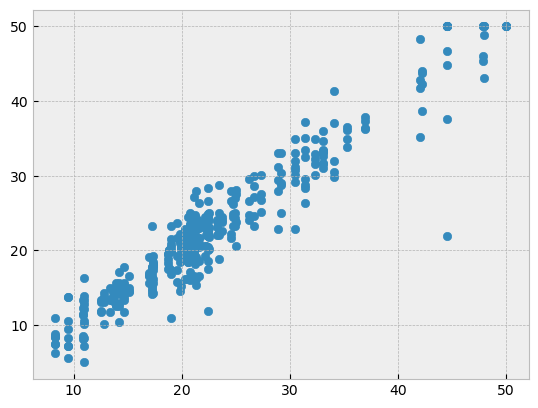

In [354]:
min_leaf = 10
dt = DecisionTree(min_leaf)
dt.fit(X_train, y_train)
y_hat = dt.predict(X_train)  # forest is the chosen model
plt.scatter(y_hat, y_train)

#### Let also check our model vs DecisionTreeRegressor from sklearn:

In [355]:
from sklearn.tree import DecisionTreeRegressor
for leaf in [1,5,10,100]:
    dtr = DecisionTreeRegressor(min_samples_leaf=leaf)
    dtr.fit(X_train, y_train)
    y_pred_test = dtr.predict(X_test)
    mse = np.mean((y_pred_test- y_test)**2) # mean square error over test set
    print(f"min_leaf:{leaf} --- oob mse: {mse:.4f}")

min_leaf:1 --- oob mse: 21.9383
min_leaf:5 --- oob mse: 15.8272
min_leaf:10 --- oob mse: 18.5874
min_leaf:100 --- oob mse: 41.2746


### Comments:

As we could see the implementaion from sklearn works faster. Most probably it have more effience implementation of finding the best split for each feature for the continius variables.

## 3. Using Decision Tree for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [356]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [357]:
# code and answer go here
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317,stratify=y)


#### Comments:
Baseline from NB exercise: The total accuracy: 0.8370

The total accuracy: 0.8702
DecisionTreeClassifier Score on TRAIN set: 1.0
DecisionTreeClassifier Score on TEST set: 0.8702


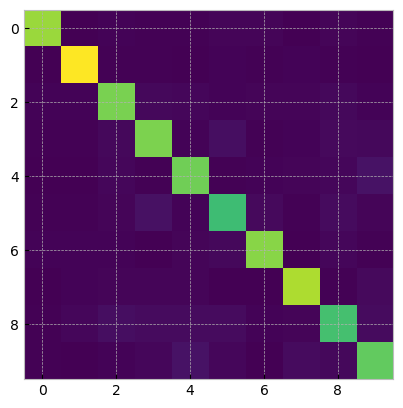

In [358]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test, y_test):.4}')

In [359]:
dtc.get_params(), dtc.get_depth()

({'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 43)

### Let's use Gridsearch for searching the best params:

In [360]:
from sklearn.model_selection import GridSearchCV

parameters = {'min_samples_leaf': (5,15,30,50,100), 'max_depth': (5,15,30,50), 'max_features':(10,25,50)} 

model = DecisionTreeClassifier()
grid_GBC = GridSearchCV(model, parameters)
grid_GBC.fit(X_train, y_train)

best_params = grid_GBC.best_params_

print(" Results from Grid Search " )
print(f'The best estimator across ALL searched params on TRAIN set: {grid_GBC.best_estimator_}')
print(f'The best score across ALL searched params on TRAIN set: {grid_GBC.best_score_:.4f}')
print(f'The best parameters across ALL searched params on TRAIN set: {best_params}')

 Results from Grid Search 
The best estimator across ALL searched params on TRAIN set: DecisionTreeClassifier(max_depth=50, max_features=50, min_samples_leaf=5)
The best score across ALL searched params on TRAIN set: 0.8386
The best parameters across ALL searched params on TRAIN set: {'max_depth': 50, 'max_features': 50, 'min_samples_leaf': 5}


The total accuracy: 0.8455
DecisionTreeClassifier Score on TRAIN set: 0.9215
DecisionTreeClassifier Score on TEST set: 0.8455


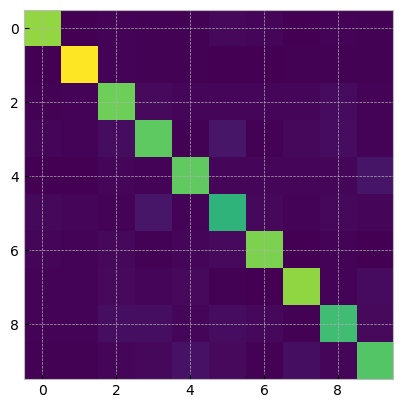

In [361]:
dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'])
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix)
print(f'The total accuracy: {np.trace(matrix)/ matrix.sum():.4f}')
print(f'DecisionTreeClassifier Score on TRAIN set: {dtc.score(X_train, y_train):.4}')
print(f'DecisionTreeClassifier Score on TEST set: {dtc.score(X_test, y_test):.4}')

#### Plot the feature importance

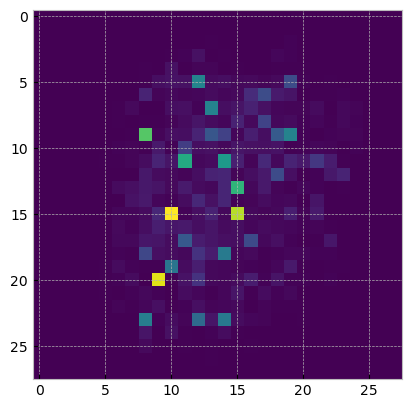

In [362]:
# Plot the feature importance
fi = dtc.feature_importances_
plt.imshow(fi.reshape(28,28))

#### Estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.

In [363]:
probabilities = dtc.predict_proba(X_test)
y_pred = dtc.predict(X_test)


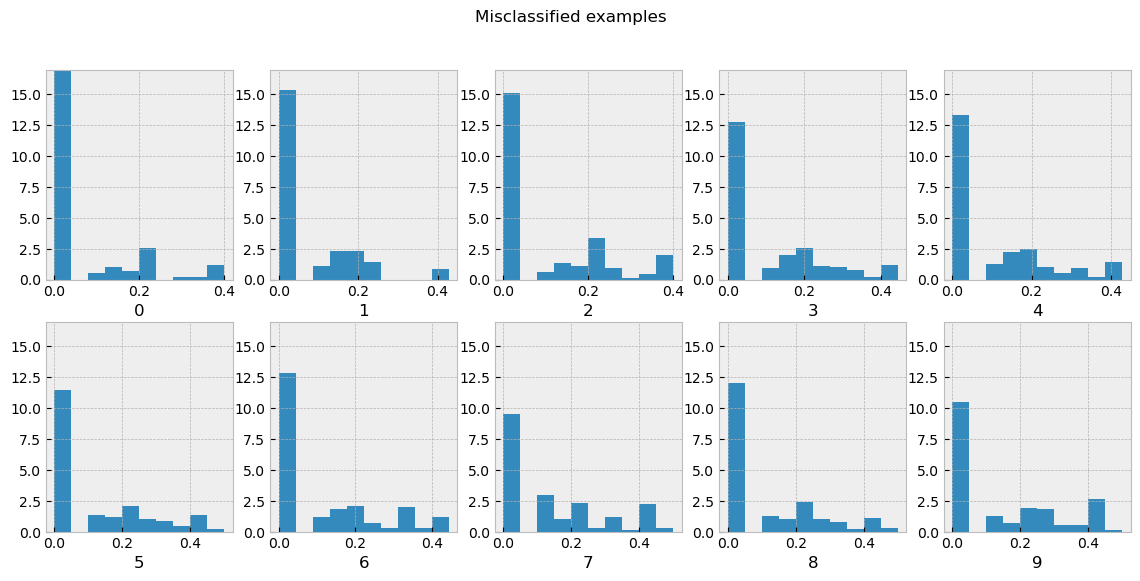

In [364]:
plt.style.use('bmh')
# plot probabilities where the model get it wrong:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(14, 6))
fig.suptitle('Misclassified examples', fontsize='large')


row = -1
for ind in range(10):
    col = ind % N_COLS
    if col == 0:
        row += 1
    indexes = (y_test == str(ind)) & (y_pred != y_test)
    axs[row,col].hist(probabilities[indexes][:,ind], density=True, bins=10)
    axs[row,col].set_xlabel(f'{ind}')
    axs[row,col].set_ylim(0, 17)


### Comments:
On this graphs for each of the digit the normalized distribution of the probabilities from the model to be predicted with the right class

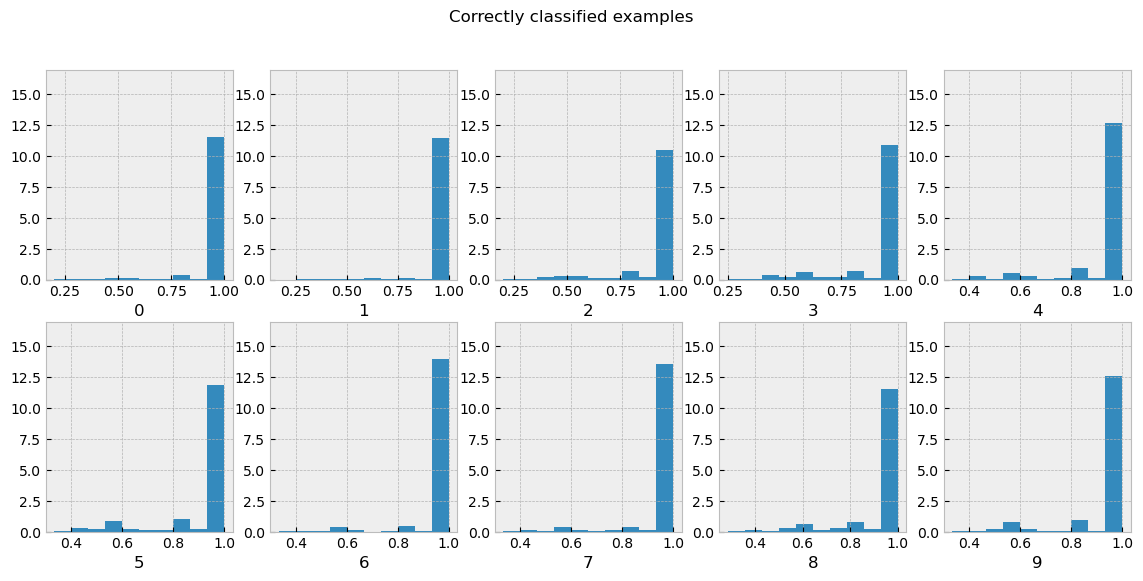

In [365]:
# plot probabilities where the model get it wrong:
N_ROWS = 2
N_COLS = 5
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(14, 6))
fig.suptitle('Correctly classified examples', fontsize='large')

row = -1
for ind in range(10):
    col = ind % N_COLS
    if col == 0:
        row += 1
    indexes = (y_test == str(ind)) & (y_pred == y_test)
    axs[row,col].hist(probabilities[indexes][:,ind], density=True, bins=10)
    axs[row,col].set_xlabel(f'{ind}')
    axs[row,col].set_ylim(0, 17)


### Comments:

We could see that for correctly classified distribution is very similar between different numbers, in contrary for the misclassified samples the difference between numbers are visible.